# Market Prices data released by OCHA

Link to the Market Prices data released by OCHA: https://data.humdata.org/ (World Food Programme (WFP) is the main source). We decided to download the data from OCHA website because they provide also the information regarding the *food groups* of the commodities.

For more details, see the *README.md*.

In [1]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ntpath
import glob
# Set a value for the column width layout.
pd.options.display.max_colwidth = 20
plt.style.use("default")

In [2]:
# Add the python path to the folder containing some custom packages.
import sys
sys.path.insert(0, "../../packages/")
from MapPlot.MapPlot import draw_adminstratas
from TsIP.TsIP import TsIP

In [3]:
# Define the path where the results arising from this analysis will be saved.
PATH_TO_SAVE_DATA = "./output_timeseries/"

In [4]:
# Read the data released by OCHA regarding the market prices indicator stored in the 'WFP_data' folder.
path = "./WFP_data/"
all_files = glob.glob(path + "*.csv")

dfs = []

# Concatenate the data of the countries in an unique dataframe.
for filename in all_files:
    df = pd.read_csv(filename, header = 1)
    df["Country"] = ntpath.basename(filename).split(".")[0]
    dfs.append(df)

# Concatenate data.
df = pd.concat(dfs, axis = 0, ignore_index = True)
# Delete duplicate rows if exist.
df = df.drop_duplicates()
df.head()

,#date,#item+name,#item+unit,#item+type,#value,#currency,#country+name,#adm1+name,#adm1+code,#name+market,Unnamed: 10,#item+code,Unnamed: 12,Unnamed: 13,#item+type+code,#meta+id,Unnamed: 16,Country
0,2020-04-15,Rice (imported) ...,KG,cereals and tubers,400.0,XOF,Burkina Faso,Boucle Du Mouhoun,40276,Tougan,141,64,15,5,1,141_64_15_5,NaN,Burkina Faso
1,2020-05-15,Rice (imported) ...,KG,cereals and tubers,400.0,XOF,Burkina Faso,Boucle Du Mouhoun,40276,Tougan,141,64,15,5,1,141_64_15_5,NaN,Burkina Faso
2,2020-06-15,Rice (imported) ...,KG,cereals and tubers,400.0,XOF,Burkina Faso,Boucle Du Mouhoun,40276,Tougan,141,64,15,5,1,141_64_15_5,NaN,Burkina Faso
3,2020-07-15,Rice (imported) ...,KG,cereals and tubers,400.0,XOF,Burkina Faso,Boucle Du Mouhoun,40276,Tougan,141,64,15,5,1,141_64_15_5,NaN,Burkina Faso
4,2020-08-15,Rice (imported) ...,KG,cereals and tubers,400.0,XOF,Burkina Faso,Boucle Du Mouhoun,40276,Tougan,141,64,15,5,1,141_64_15_5,NaN,Burkina Faso


In [5]:
not_unique = df.set_index(["Country", "#adm1+name", "#item+type", "#item+name", "#date", "#name+market"]).sort_index()
not_unique.index.is_unique

True

In [6]:
# Rename some columns names.
df.rename(columns = {"#date": "Datetime", "#item+name": "Commodity", "#item+unit": "Unit", "#item+type": "Food Group", "#value": "Price", "#currency": "Currency", "#adm1+name": "AdminStrata"}, inplace = True)
# Select only some feature items.
df = df[["Datetime", "Commodity", "Unit", "Food Group", "Price", "Currency", "AdminStrata", "Country"]]
df.head()

,Datetime,Commodity,Unit,Food Group,Price,Currency,AdminStrata,Country
0,2020-04-15,Rice (imported) ...,KG,cereals and tubers,400.0,XOF,Boucle Du Mouhoun,Burkina Faso
1,2020-05-15,Rice (imported) ...,KG,cereals and tubers,400.0,XOF,Boucle Du Mouhoun,Burkina Faso
2,2020-06-15,Rice (imported) ...,KG,cereals and tubers,400.0,XOF,Boucle Du Mouhoun,Burkina Faso
3,2020-07-15,Rice (imported) ...,KG,cereals and tubers,400.0,XOF,Boucle Du Mouhoun,Burkina Faso
4,2020-08-15,Rice (imported) ...,KG,cereals and tubers,400.0,XOF,Boucle Du Mouhoun,Burkina Faso


In [7]:
# Read the extra information regarding the exchange rate of only Burkina Faso country (unique among the provinces).
exchange_rate_burkina = pd.read_csv("./WFP_data/Exchange_rate/Exchange_rate_Burkina.csv")
exchange_rate_burkina.head()

,economicdatasymbol,date,economicdatavalue,countryiso3,source
0,USDXOF,1/1/2019,569.22,BFA,Trading Economics
1,USDXOF,1/2/2019,569.22,BFA,Trading Economics
2,USDXOF,1/3/2019,573.48,BFA,Trading Economics
3,USDXOF,1/4/2019,573.45,BFA,Trading Economics
4,USDXOF,1/7/2019,571.00,BFA,Trading Economics


In [8]:
# Rename some columns names.
exchange_rate_burkina.rename(columns = {"date": "Datetime", "economicdatavalue": "Price"}, inplace = True)
# Select only some feature items.
exchange_rate_burkina = exchange_rate_burkina[["Datetime", "Price"]]
exchange_rate_burkina[["Commodity", "Food Group", "Unit", "Currency", "Country"]] = ["Exchange rate", "non-food", "USD/LCU", "XOF", "Burkina Faso"]
exchange_rate_burkina["AdminStrata"] = [df[df.Country == "Burkina Faso"].AdminStrata.unique().tolist()]*len(exchange_rate_burkina)
exchange_rate_burkina = exchange_rate_burkina.explode("AdminStrata")
exchange_rate_burkina.reset_index(drop = True, inplace = True)
exchange_rate_burkina.head()

,Datetime,Price,Commodity,Food Group,Unit,Currency,Country,AdminStrata
0,1/1/2019,569.22,Exchange rate,non-food,USD/LCU,XOF,Burkina Faso,Boucle Du Mouhoun
1,1/1/2019,569.22,Exchange rate,non-food,USD/LCU,XOF,Burkina Faso,Cascades
2,1/1/2019,569.22,Exchange rate,non-food,USD/LCU,XOF,Burkina Faso,Centre
3,1/1/2019,569.22,Exchange rate,non-food,USD/LCU,XOF,Burkina Faso,Centre-est
4,1/1/2019,569.22,Exchange rate,non-food,USD/LCU,XOF,Burkina Faso,Centre-nord


In [9]:
# Concatenate two dataframes.
df = pd.concat([df, exchange_rate_burkina], axis = 0).reset_index(drop = True)

The data have a monthly granularity. We convert the temporal information to an appropriate pandas datetime object selecting the data beyond a defined year in order to reduce the amount of data to analyze. The 15th of the month is used as a convention to indicate that the price is valid for the corresponding entire month.

In [10]:
# Creation of an accurate datetime format.
df["Datetime"] = pd.to_datetime(df["Datetime"])
df.sort_values("Datetime", ascending = True, inplace = True) 
df.reset_index(drop = True, inplace = True)
df.head()

,Datetime,Commodity,Unit,Food Group,Price,Currency,AdminStrata,Country
0,1992-01-15,Millet - Retail,KG,cereals and tubers,77.00,XOF,Centre-est,Burkina Faso
1,1992-01-15,Millet - Retail,KG,cereals and tubers,64.00,XOF,Sud-ouest,Burkina Faso
2,1992-01-15,Millet - Retail,KG,cereals and tubers,69.00,XOF,Centre-ouest,Burkina Faso
3,1992-01-15,Millet - Retail,KG,cereals and tubers,75.75,XOF,Sahel,Burkina Faso
4,1992-01-15,Millet - Retail,KG,cereals and tubers,57.67,XOF,Sahel,Burkina Faso


In [11]:
# Select only the data beyond this year (the year is chosen based on the coverage of the FCG <= 2 survey).
year = 2018

In [12]:
df = df.loc[pd.DatetimeIndex(df.Datetime).year >= year]
df.reset_index(drop = True, inplace = True)
df.head()

,Datetime,Commodity,Unit,Food Group,Price,Currency,AdminStrata,Country
0,2018-01-15,Onions - Retail,KG,vegetables and f...,312.50,YER,Hajjah,Yemen
1,2018-01-15,Groundnuts (unsh...,KG,pulses and nuts,265.00,XOF,Boucle Du Mouhoun,Burkina Faso
2,2018-01-15,Oil (vegetable) ...,L,oil and fats,448.75,YER,Ibb,Yemen
3,2018-01-15,Onions - Retail,KG,vegetables and f...,275.00,YER,Raymah,Yemen
4,2018-01-15,Wheat - Retail,KG,cereals and tubers,180.00,YER,Dhamar,Yemen


### Brief items description

In [13]:
# Check if the dataframe contains NaN values.
df.isnull().sum()

Datetime       0
Commodity      0
Unit           0
Food Group     0
Price          0
Currency       0
AdminStrata    0
Country        0
dtype: int64

### Country item

In [14]:
print("The countries in the dataset are:", ", ".join(df.Country.unique()))

The countries in the dataset are: Yemen, Burkina Faso


### AdminStrata item

In [15]:
# Rename the name of some administrative regions of Burkina Faso.
df.loc[df.Country == "Burkina Faso", "AdminStrata"] = df.loc[df.Country == "Burkina Faso", "AdminStrata"].replace(["Boucle Du Mouhoun", "Sud-ouest", "Plateau Central", "Centre-est", "Centre-ouest", "Centre-nord", "Centre-sud", "Hauts-bassins", "North", "East", "Central"], 
                                                                                                                  ["Boucle-Du-Mouhoun", "Sud-Ouest", "Plateau-Central", "Centre-Est", "Centre-Ouest", "Centre-Nord", "Centre-Sud", "Hauts-Bassins", "Nord", "Est", "Centre"])

In [16]:
AdminStratas = df.groupby("Country")["AdminStrata"].unique()

- **Yemen (YEM)**: the administrative regions of Yemen are 22, including the capital Sana'a (Amanat Al Asimah) and Socotra archipelago.  The market prices dataframe has the values of 21 administrative regions (Socotra not included; more precisely, Socotra is considered into the Hadramaut administrative region. In fact, a market of Hadramaut administrative region is placed on Socotra island).

In [17]:
print(AdminStratas["Yemen"].shape)
AdminStratas["Yemen"]

(21,)


array(['Hajjah', 'Ibb', 'Raymah', 'Dhamar', 'Al Hudaydah', 'Amran',
       'Marib', 'Al Maharah', 'Abyan', 'Aden', "Sa'ada",
       'Amanat Al Asimah', 'Hadramaut', 'Lahj', 'Al Jawf', 'Al Bayda',
       "Sana'a", 'Shabwah', 'Taizz', "Al Dhale'e", 'Al Mahwit'],
      dtype=object)

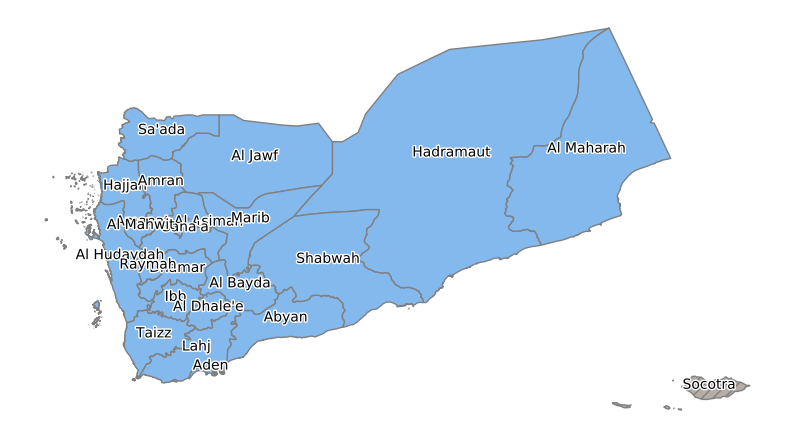

In [18]:
draw_adminstratas("Yemen", AdminStratas["Yemen"], AdminStratas["Yemen"], "../1. Shape Files/output_shapefiles/Yemen/administrative_level_1/Yemen.shp", figsize = (10, 7), 
                  annotation = True, path_to_save = PATH_TO_SAVE_DATA + "Yemen/map_fcs_yemen.png", dpi = 300)

- **Burkina Faso (BFA)**: Burkina Faso is divided into 13 administrative regions. The food prices dataframe has the values of all 13 administrative regions.

In [19]:
print(AdminStratas["Burkina Faso"].shape)
AdminStratas["Burkina Faso"]

(13,)


array(['Boucle-Du-Mouhoun', 'Sud-Ouest', 'Centre-Est', 'Est',
       'Hauts-Bassins', 'Nord', 'Centre-Nord', 'Centre', 'Sahel',
       'Plateau-Central', 'Centre-Sud', 'Centre-Ouest', 'Cascades'],
      dtype=object)

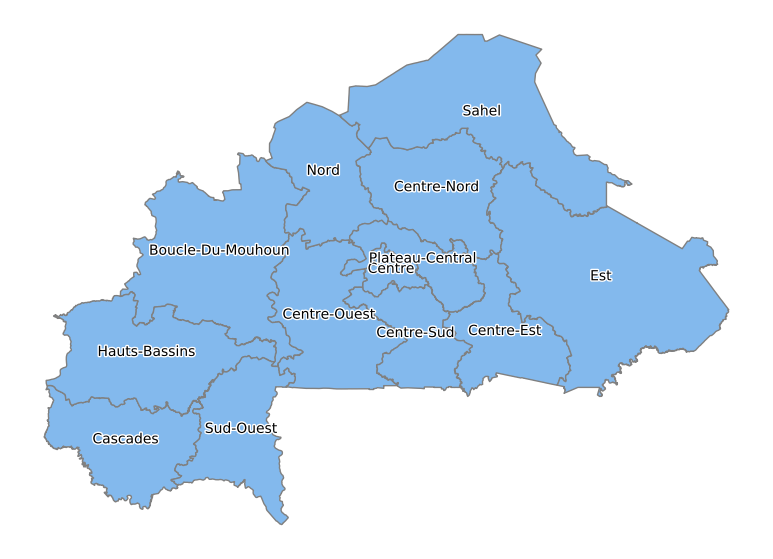

In [20]:
draw_adminstratas("Burkina Faso", AdminStratas["Burkina Faso"], AdminStratas["Burkina Faso"], "../1. Shape Files/output_shapefiles/Burkina Faso/administrative_level_1/Burkina Faso.shp", figsize = (10, 7), 
                  annotation = True, path_to_save = PATH_TO_SAVE_DATA + "Burkina Faso/map_fcs_burkina.png", dpi = 300)

### Administrative regions reduction based on FCG <= 2 survey coverage

In [21]:
for country in df.Country.unique():
    # Get the information regarding the administrative regions covered by the Food Consumption Score survey.
    fcs_coverage = pd.read_csv("../2. Food Consumption Score (FCS)/output_timeseries/%s/wfp_fcs-SvyDateRange.csv" % country, header = [0, 1], index_col = 0)
    adminstratas = fcs_coverage.columns.get_level_values(0).unique()
    # Filtering on the administrative regions.
    df = df[((df.Country == country) & (df.AdminStrata.isin(adminstratas))) | (df.Country != country)]

### Market prices preprocessing

In [22]:
print("The types of commodities:")
np.sort(df.Commodity.unique())

The types of commodities:


array(['Beans (kidney red) - Retail', 'Beans (niebe) - Retail',
       'Beans (white) - Retail', 'Eggs - Retail', 'Exchange rate',
       'Exchange rate (unofficial) - Retail', 'Fuel (diesel) - Retail',
       'Fuel (gas) - Retail', 'Fuel (petrol-gasoline) - Retail',
       'Groundnuts (shelled) - Retail', 'Groundnuts (unshelled) - Retail',
       'Lentils - Retail',
       'Livestock (sheep, two-year-old male) - Retail',
       'Maize (white) - Retail', 'Meat (chicken) - Retail',
       'Meat (mutton) - Retail', 'Millet - Retail', 'Millet - Wholesale',
       'Milling cost (wheat) - Retail', 'Oil (vegetable) - Retail',
       'Onions - Retail', 'Peas (yellow, split) - Retail',
       'Potatoes - Retail', 'Rice (imported) - Retail',
       'Rice (imported) - Wholesale', 'Rice (local) - Retail',
       'Salt - Retail', 'Sorghum (local) - Wholesale',
       'Sorghum (white) - Retail', 'Sorghum - Retail', 'Sugar - Retail',
       'Tomatoes - Retail', 'Wage (non-qualified labour) - Retail'

N.B. Not all the administrative regions have a time-series for all these commodities.

In [23]:
print("The types of food groups:")
np.sort(df["Food Group"].unique())

The types of food groups:


array(['cereals and tubers', 'meat, fish and eggs', 'miscellaneous food',
       'non-food', 'oil and fats', 'pulses and nuts',
       'vegetables and fruits'], dtype=object)

In [24]:
def select_non_food(group):
    if group.name == "non-food":
        # Keep the commodities about the exchange rate.
        group.loc[group.Commodity.str.contains("Exchange rate"), "Food Group"] = "Exchange rate"
        return group
    else:
        return group

df = df.groupby("Food Group", group_keys = False).apply(select_non_food)

In [25]:
# Select sub-dataframe considering only the 'Cereals and tubers' and the 'Exchange rate'.
df = df.loc[(df["Food Group"] == "Exchange rate") | (df["Food Group"] == "cereals and tubers")]
df.head()

,Datetime,Commodity,Unit,Food Group,Price,Currency,AdminStrata,Country
4,2018-01-15,Wheat - Retail,KG,cereals and tubers,180.0,YER,Dhamar,Yemen
8,2018-01-15,Wheat - Retail,KG,cereals and tubers,160.0,YER,Marib,Yemen
10,2018-01-15,Potatoes - Retail,KG,cereals and tubers,300.0,YER,Marib,Yemen
11,2018-01-15,Maize (white) - ...,KG,cereals and tubers,143.0,XOF,Centre-Est,Burkina Faso
12,2018-01-15,Maize (white) - ...,KG,cereals and tubers,130.0,XOF,Est,Burkina Faso


In [26]:
print("The types of food groups:")
df["Food Group"].unique()

The types of food groups:


array(['cereals and tubers', 'Exchange rate'], dtype=object)

In [27]:
print("The unit of measure of the commodities:")
df.Unit.unique()

The unit of measure of the commodities:


array(['KG', 'USD/LCU', '100 KG'], dtype=object)

In [28]:
# Check if some commodities are measured using multiple unit types among the provinces of the same countries.
commodities_units = dict()

def unit_check(group):
    if len(group.Unit.unique()) > 1:
        commodities_units[(group.Commodity.unique()[0], group.Country.unique()[0])] = list(group.Unit.unique())

df.groupby(["Country", "Commodity"]).apply(unit_check);
print(commodities_units)

{}


In [29]:
# Add a suffix to each commodity corresponding to the unit value.
def add_unit(row):
    commodity = row.Commodity
    unit = row.Unit
    return pd.Series([commodity + " (" + unit + ")", unit])

df[["Commodity", "Unit"]] = df.apply(add_unit, axis = 1)
df.head()

,Datetime,Commodity,Unit,Food Group,Price,Currency,AdminStrata,Country
4,2018-01-15,Wheat - Retail (KG),KG,cereals and tubers,180.0,YER,Dhamar,Yemen
8,2018-01-15,Wheat - Retail (KG),KG,cereals and tubers,160.0,YER,Marib,Yemen
10,2018-01-15,Potatoes - Retai...,KG,cereals and tubers,300.0,YER,Marib,Yemen
11,2018-01-15,Maize (white) - ...,KG,cereals and tubers,143.0,XOF,Centre-Est,Burkina Faso
12,2018-01-15,Maize (white) - ...,KG,cereals and tubers,130.0,XOF,Est,Burkina Faso


In [30]:
# The unique currency.
df.groupby("Country")["Currency"].unique()

Country
Burkina Faso    [XOF]
Yemen           [YER]
Name: Currency, dtype: object

In [31]:
# Delete the unutilized columns in this notebook.
df.drop(labels = ["Unit", "Currency"], axis = 1, inplace = True)
df.head()

,Datetime,Commodity,Food Group,Price,AdminStrata,Country
4,2018-01-15,Wheat - Retail (KG),cereals and tubers,180.0,Dhamar,Yemen
8,2018-01-15,Wheat - Retail (KG),cereals and tubers,160.0,Marib,Yemen
10,2018-01-15,Potatoes - Retai...,cereals and tubers,300.0,Marib,Yemen
11,2018-01-15,Maize (white) - ...,cereals and tubers,143.0,Centre-Est,Burkina Faso
12,2018-01-15,Maize (white) - ...,cereals and tubers,130.0,Est,Burkina Faso


## Creation of the time-series

In [32]:
not_unique = df.set_index(["Country", "AdminStrata", "Food Group", "Commodity", "Datetime"]).sort_index()
not_unique.index.is_unique

False

In [33]:
not_unique.loc[not_unique.index.value_counts() > 1]

Price
Country      AdminStrata       Food Group         Commodity            Datetime         
Burkina Faso Boucle-Du-Mouhoun cereals and tubers Maize (white) - R... 2018-01-15  139.0
                                                                       2018-01-15  163.0
                                                                       2018-01-15  127.0
                                                                       2018-01-15  167.0
                                                                       2018-01-15  181.0
...                                                                                  ...
Yemen        Hajjah            cereals and tubers Wheat flour - Ret... 2019-11-15  272.5
                                                                       2020-01-15  288.0
                                                                       2020-01-15  270.0
                                                                       2020-02-15  300.0
                                                                       2020-02-15  270.0

[8604 rows x 1 columns]

N.B. The field '#name+market' made unique the index.

In [34]:
# Create appropriate time-series sub-groups with an appropriate datetime object sampling to the end of the months.
# If for the same date and commodity a province has more than one market price, the mean is taken.
df = df.groupby(["Country", "AdminStrata", "Food Group", "Commodity"]).apply(lambda group: group.set_index("Datetime").resample("M").mean()).reset_index()
df.reset_index(drop = True, inplace = True)
df.head()

,Country,AdminStrata,Food Group,Commodity,Datetime,Price
0,Burkina Faso,Boucle-Du-Mouhoun,Exchange rate,Exchange rate (U...,2019-01-31,571.391739
1,Burkina Faso,Boucle-Du-Mouhoun,Exchange rate,Exchange rate (U...,2019-02-28,574.329000
2,Burkina Faso,Boucle-Du-Mouhoun,Exchange rate,Exchange rate (U...,2019-03-31,576.081429
3,Burkina Faso,Boucle-Du-Mouhoun,Exchange rate,Exchange rate (U...,2019-04-30,580.365909
4,Burkina Faso,Boucle-Du-Mouhoun,Exchange rate,Exchange rate (U...,2019-05-31,582.490870


In [35]:
# Create a dataframe with multi-index column in order to have a summary dataframe of the time-series.
df = df.set_index(["Datetime", "Country", "AdminStrata", "Food Group", "Commodity"]).unstack(["Country", "AdminStrata", "Food Group", "Commodity"])
df.columns = df.columns.droplevel(0)
df.sort_index(axis = 1, level = [0, 1, 2, 3], inplace = True)
df.rename({"cereals and tubers": "Price cereals and tubers"}, axis = 1, level = 2, inplace = True)
freq = "M"
df.index.freq = freq
df.head()

Country                Burkina Faso                              \
AdminStrata       Boucle-Du-Mouhoun                               
Food Group            Exchange rate    Price cereals and tubers   
Commodity   Exchange rate (USD/LCU) Maize (white) - Retail (KG)   
Datetime                                                          
2018-01-31                   NaN                 155.625          
2018-02-28                   NaN                 159.500          
2018-03-31                   NaN                 163.875          
2018-04-30                   NaN                 167.125          
2018-05-31                   NaN                 170.250          

Country                                                       \
AdminStrata                                                    
Food Group                                                     
Commodity   Millet - Retail (KG) Millet - Wholesale (100 KG)   
Datetime                                                       
2018-01-31            186.111111              19250.0          
2018-02-28            198.888889              21500.0          
2018-03-31            203.222222              21500.0          
2018-04-30            206.333333              21500.0          
2018-05-31            214.111111              21500.0          

Country                                    \
AdminStrata                                 
Food Group                                  
Commodity   Rice (imported) - Retail (KG)   
Datetime                                    
2018-01-31            382.666667            
2018-02-28            391.666667            
2018-03-31            395.666667            
2018-04-30            395.000000            
2018-05-31            401.666667            

Country                                                                      \
AdminStrata                                                                   
Food Group                                                                    
Commodity   Rice (imported) - Wholesale (100 KG) Rice (local) - Retail (KG)   
Datetime                                                                      
2018-01-31               40000.0                                292.6         
2018-02-28               40000.0                                289.0         
2018-03-31               40000.0                                304.4         
2018-04-30               40000.0                                306.2         
2018-05-31               40000.0                                304.8         

Country                                           \
AdminStrata                                        
Food Group                                         
Commodity   Sorghum (local) - Wholesale (100 KG)   
Datetime                                           
2018-01-31               16250.0                   
2018-02-28               17000.0                   
2018-03-31               17750.0                   
2018-04-30               18000.0                   
2018-05-31               18000.0                   

Country                                                            ...  \
AdminStrata                                              Cascades  ...   
Food Group                                          Exchange rate  ...   
Commodity   Sorghum (white) - Retail (KG) Exchange rate (USD/LCU)  ...   
Datetime                                                           ...   
2018-01-31            160.333333                           NaN     ...   
2018-02-28            168.111111                           NaN     ...   
2018-03-31            181.444444                           NaN     ...   
2018-04-30            177.555556                           NaN     ...   
2018-05-31            182.666667                           NaN     ...   

Country                                             Yemen  \
AdminStrata                                       Shabwah   
Food Group                                  Exchange rate   
C

In [36]:
# Plot the time-series.
TsIP(df).interactive_plot_df(matplotlib = False, style = "lines+markers", yaxis = "Market prices", first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Time-series')

Output()

In [37]:
# Now save the time-series at country level keeping as indeces for each time-series the own first and last index.
def save(group, name):
    country = group.name
    group = group[country]
    # Adjust time-series group.
    first_idx = group.first_valid_index()
    last_idx = group.last_valid_index()
    group = group.loc[first_idx:last_idx]
    # Save.
    group.to_csv(PATH_TO_SAVE_DATA + country + "/" + name + ".csv", index_label = False)

In [38]:
# Save the time-series.
df.groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_relevant_market_price-month"));

## Adjustment of the time-series (interpolation of some NaN values)

In [39]:
# Let's interpolate the NaN values using a linear interpolation up to a limit of 3 months.
def interpolation(group): 
    group = group.loc[group.first_valid_index():group.last_valid_index()]
    group = group.interpolate(method = "linear", limit = 3)
    # Delete time-series that still has some NaN values in its last temporal part.
    if group.isna().any().any():
        # Keep only last temporal part of the time-series.
        events = np.split(group, np.where(np.isnan(group.values))[0])
        # Removing NaN entries.
        events = [ev[~np.isnan(ev.values)] for ev in events if not isinstance(ev, np.ndarray)]
        # Removing empty DataFrames.
        events = [ev for ev in events if not ev.empty]
        # Last event (70%).
        last_event = events[-1]
        if len(last_event) >= int(0.7*len(group)):
            return last_event
        else:
            group.dropna(inplace = True, axis = 1)
            return group
    else:
        return group

df_interpolate = df.groupby(axis = 1, level = [0, 1, 2, 3], group_keys = False).apply(interpolation)
df_interpolate.head()

Country                Burkina Faso                              \
AdminStrata       Boucle-Du-Mouhoun                               
Food Group            Exchange rate    Price cereals and tubers   
Commodity   Exchange rate (USD/LCU) Maize (white) - Retail (KG)   
Datetime                                                          
2018-01-31                   NaN                 155.625          
2018-02-28                   NaN                 159.500          
2018-03-31                   NaN                 163.875          
2018-04-30                   NaN                 167.125          
2018-05-31                   NaN                 170.250          

Country                                                       \
AdminStrata                                                    
Food Group                                                     
Commodity   Millet - Retail (KG) Millet - Wholesale (100 KG)   
Datetime                                                       
2018-01-31            186.111111              19250.0          
2018-02-28            198.888889              21500.0          
2018-03-31            203.222222              21500.0          
2018-04-30            206.333333              21500.0          
2018-05-31            214.111111              21500.0          

Country                                    \
AdminStrata                                 
Food Group                                  
Commodity   Rice (imported) - Retail (KG)   
Datetime                                    
2018-01-31            382.666667            
2018-02-28            391.666667            
2018-03-31            395.666667            
2018-04-30            395.000000            
2018-05-31            401.666667            

Country                                                                      \
AdminStrata                                                                   
Food Group                                                                    
Commodity   Rice (imported) - Wholesale (100 KG) Rice (local) - Retail (KG)   
Datetime                                                                      
2018-01-31               40000.0                                292.6         
2018-02-28               40000.0                                289.0         
2018-03-31               40000.0                                304.4         
2018-04-30               40000.0                                306.2         
2018-05-31               40000.0                                304.8         

Country                                           \
AdminStrata                                        
Food Group                                         
Commodity   Sorghum (local) - Wholesale (100 KG)   
Datetime                                           
2018-01-31               16250.0                   
2018-02-28               17000.0                   
2018-03-31               17750.0                   
2018-04-30               18000.0                   
2018-05-31               18000.0                   

Country                                                            ...  \
AdminStrata                                              Cascades  ...   
Food Group                                          Exchange rate  ...   
Commodity   Sorghum (white) - Retail (KG) Exchange rate (USD/LCU)  ...   
Datetime                                                           ...   
2018-01-31            160.333333                           NaN     ...   
2018-02-28            168.111111                           NaN     ...   
2018-03-31            181.444444                           NaN     ...   
2018-04-30            177.555556                           NaN     ...   
2018-05-31            182.666667                           NaN     ...   

Country                                             Yemen  \
AdminStrata                                       Shabwah   
Food Group                                  Exchange rate   
C

In [40]:
# Check what time-series are dropped.
for column in df.columns:
    if column not in df_interpolate.columns:
        print(column)

('Burkina Faso', 'Centre-Sud', 'Price cereals and tubers', 'Rice (imported) - Retail (KG)')
('Yemen', 'Amanat Al Asimah', 'Price cereals and tubers', 'Millet - Retail (KG)')
('Yemen', 'Amanat Al Asimah', 'Price cereals and tubers', 'Sorghum - Retail (KG)')


In [41]:
# Plot time-series.
TsIP(df_interpolate).interactive_plot_df(matplotlib = False, style = "lines+markers", yaxis = "Market prices", first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Time-series')

Output()

In [42]:
# Save the time-series.
df_interpolate.groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_relevant_market_price-interpolate-month"));

## Common commodities

We select only the commodities that are in common between the adminstrative regions of the same country.

In [43]:
# Keep only the commodities that are commons to each adminstrata of the same country.
def common_commodities(group):
    commodities = list()
    
    def func(group):
        commodities_admin = list(group.columns.get_level_values(3))
        commodities.append(commodities_admin)

    group.groupby(axis = 1, level = [0, 1]).apply(func);
    # Select the commodities that are in common.
    common = list(set.intersection(*map(set, commodities)))
    group_common = group.iloc[:, group.columns.get_level_values(3).isin(common)]
    return group_common

df_common = df_interpolate.groupby(axis = 1, level = 0, group_keys = False).apply(common_commodities).dropna(axis = 1, how = "all")
df_common.head()

Country                Burkina Faso                              \
AdminStrata       Boucle-Du-Mouhoun                               
Food Group            Exchange rate    Price cereals and tubers   
Commodity   Exchange rate (USD/LCU) Maize (white) - Retail (KG)   
Datetime                                                          
2018-01-31                   NaN                 155.625          
2018-02-28                   NaN                 159.500          
2018-03-31                   NaN                 163.875          
2018-04-30                   NaN                 167.125          
2018-05-31                   NaN                 170.250          

Country                                                         \
AdminStrata                                                      
Food Group                                                       
Commodity   Millet - Retail (KG) Sorghum (white) - Retail (KG)   
Datetime                                                         
2018-01-31            186.111111           160.333333            
2018-02-28            198.888889           168.111111            
2018-03-31            203.222222           181.444444            
2018-04-30            206.333333           177.555556            
2018-05-31            214.111111           182.666667            

Country                                                          \
AdminStrata                Cascades                               
Food Group            Exchange rate    Price cereals and tubers   
Commodity   Exchange rate (USD/LCU) Maize (white) - Retail (KG)   
Datetime                                                          
2018-01-31                   NaN                   120.0          
2018-02-28                   NaN                   130.0          
2018-03-31                   NaN                   146.5          
2018-04-30                   NaN                   154.0          
2018-05-31                   NaN                   154.0          

Country                                                         \
AdminStrata                                                      
Food Group                                                       
Commodity   Millet - Retail (KG) Sorghum (white) - Retail (KG)   
Datetime                                                         
2018-01-31                 250.0                187.5            
2018-02-28                 250.0                212.5            
2018-03-31                 253.0                212.5            
2018-04-30                 272.0                212.5            
2018-05-31                 275.0                219.0            

Country                                                          ...  \
AdminStrata                  Centre                              ...   
Food Group            Exchange rate    Price cereals and tubers  ...   
Commodity   Exchange rate (USD/LCU) Maize (white) - Retail (KG)  ...   
Datetime                                                         ...   
2018-01-31                   NaN                   168.5         ...   
2018-02-28                   NaN                   181.5         ...   
2018-03-31                   NaN                   190.5         ...   
2018-04-30                   NaN                   187.0         ...   
2018-05-31                   NaN                   186.0         ...   

Country                                             Yemen  \
AdminStrata                                       Shabwah   
Food Group                                  Exchange rate   
Commodity   Exchange rate (unofficial) - Retail (USD/LCU)   
Datetime                                                    
2018-01-31                455.00                            
2018-02-28                471.75                            
2018-03-31                472.50                            
2018-04-30                650.00                            
2018-05-31                485.00                            

Coun

In [44]:
# Plot time-series.
TsIP(df_common).interactive_plot_df(matplotlib = False, style = "lines+markers", yaxis = "Market prices", first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Time-series')

Output()

### Normalization

Let's perform a simple normalization of the food prices over the commodities of all the provinces of the same country in order to subsequently take the mean of the commodities into the same food group.

In [45]:
def normalization(group):
    group_scaled = group.stack([1, 2])
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(group_scaled)
    group_scaled[:] = scaled_data
    group_scaled = group_scaled.unstack([1, 2]).reorder_levels([0, 2, 3, 1], axis = 1).sort_index(axis = 1, level = [0, 1, 2, 3])
    group_scaled = group_scaled.dropna(axis = 1, how = "all")
    return group_scaled

df_norm = df_common.groupby(axis = 1, level = 0, group_keys = False).apply(normalization)
df_norm.head()

Country                Burkina Faso                              \
AdminStrata       Boucle-Du-Mouhoun                               
Food Group            Exchange rate    Price cereals and tubers   
Commodity   Exchange rate (USD/LCU) Maize (white) - Retail (KG)   
Datetime                                                          
2018-01-31                   NaN                0.457862          
2018-02-28                   NaN                0.484163          
2018-03-31                   NaN                0.513857          
2018-04-30                   NaN                0.535916          
2018-05-31                   NaN                0.557127          

Country                                                         \
AdminStrata                                                      
Food Group                                                       
Commodity   Millet - Retail (KG) Sorghum (white) - Retail (KG)   
Datetime                                                         
2018-01-31              0.360261             0.400932            
2018-02-28              0.439326             0.455322            
2018-03-31              0.466140             0.548563            
2018-04-30              0.485390             0.521368            
2018-05-31              0.533517             0.557110            

Country                                                          \
AdminStrata                Cascades                               
Food Group            Exchange rate    Price cereals and tubers   
Commodity   Exchange rate (USD/LCU) Maize (white) - Retail (KG)   
Datetime                                                          
2018-01-31                   NaN                0.216063          
2018-02-28                   NaN                0.283937          
2018-03-31                   NaN                0.395928          
2018-04-30                   NaN                0.446833          
2018-05-31                   NaN                0.446833          

Country                                                         \
AdminStrata                                                      
Food Group                                                       
Commodity   Millet - Retail (KG) Sorghum (white) - Retail (KG)   
Datetime                                                         
2018-01-31              0.755586             0.590909            
2018-02-28              0.755586             0.765734            
2018-03-31              0.774149             0.765734            
2018-04-30              0.891715             0.765734            
2018-05-31              0.910278             0.811189            

Country                                                          ...  \
AdminStrata                  Centre                              ...   
Food Group            Exchange rate    Price cereals and tubers  ...   
Commodity   Exchange rate (USD/LCU) Maize (white) - Retail (KG)  ...   
Datetime                                                         ...   
2018-01-31                   NaN                0.545249         ...   
2018-02-28                   NaN                0.633484         ...   
2018-03-31                   NaN                0.694570         ...   
2018-04-30                   NaN                0.670814         ...   
2018-05-31                   NaN                0.664027         ...   

Country                                             Yemen  \
AdminStrata                                       Shabwah   
Food Group                                  Exchange rate   
Commodity   Exchange rate (unofficial) - Retail (USD/LCU)   
Datetime                                                    
2018-01-31              0.043478                            
2018-02-28              0.075845                            
2018-03-31              0.077295                            
2018-04-30              0.420290                            
2018-05-31              0.101449                            

Coun

In [46]:
# Plot time-series.
TsIP(df_norm).interactive_plot_df(matplotlib = False, style = "lines+markers", yaxis = "Market prices", first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Time-series')

Output()

In [47]:
# Resample data to daily level.
def resample_day(group):   
    first_idx = group.first_valid_index()
    last_idx = group.last_valid_index()
    group = group.loc[first_idx:last_idx]
    group = group.resample("D").first()
    return group

df_norm_fit = df_norm.groupby(axis = 1, level = [0, 1, 2, 3], group_keys = False).apply(resample_day)
freq = "D"
df_norm_fit.index.freq = freq
df_norm_fit.head()

Country                Burkina Faso                              \
AdminStrata       Boucle-Du-Mouhoun                               
Food Group            Exchange rate    Price cereals and tubers   
Commodity   Exchange rate (USD/LCU) Maize (white) - Retail (KG)   
Datetime                                                          
2018-01-31                   NaN                0.457862          
2018-02-01                   NaN                     NaN          
2018-02-02                   NaN                     NaN          
2018-02-03                   NaN                     NaN          
2018-02-04                   NaN                     NaN          

Country                                                         \
AdminStrata                                                      
Food Group                                                       
Commodity   Millet - Retail (KG) Sorghum (white) - Retail (KG)   
Datetime                                                         
2018-01-31              0.360261             0.400932            
2018-02-01                   NaN                  NaN            
2018-02-02                   NaN                  NaN            
2018-02-03                   NaN                  NaN            
2018-02-04                   NaN                  NaN            

Country                                                          \
AdminStrata                Cascades                               
Food Group            Exchange rate    Price cereals and tubers   
Commodity   Exchange rate (USD/LCU) Maize (white) - Retail (KG)   
Datetime                                                          
2018-01-31                   NaN                0.216063          
2018-02-01                   NaN                     NaN          
2018-02-02                   NaN                     NaN          
2018-02-03                   NaN                     NaN          
2018-02-04                   NaN                     NaN          

Country                                                         \
AdminStrata                                                      
Food Group                                                       
Commodity   Millet - Retail (KG) Sorghum (white) - Retail (KG)   
Datetime                                                         
2018-01-31              0.755586             0.590909            
2018-02-01                   NaN                  NaN            
2018-02-02                   NaN                  NaN            
2018-02-03                   NaN                  NaN            
2018-02-04                   NaN                  NaN            

Country                                                          ...  \
AdminStrata                  Centre                              ...   
Food Group            Exchange rate    Price cereals and tubers  ...   
Commodity   Exchange rate (USD/LCU) Maize (white) - Retail (KG)  ...   
Datetime                                                         ...   
2018-01-31                   NaN                0.545249         ...   
2018-02-01                   NaN                     NaN         ...   
2018-02-02                   NaN                     NaN         ...   
2018-02-03                   NaN                     NaN         ...   
2018-02-04                   NaN                     NaN         ...   

Country                                             Yemen  \
AdminStrata                                       Shabwah   
Food Group                                  Exchange rate   
Commodity   Exchange rate (unofficial) - Retail (USD/LCU)   
Datetime                                                    
2018-01-31              0.043478                            
2018-02-01                   NaN                            
2018-02-02                   NaN                            
2018-02-03                   NaN                            
2018-02-04                   NaN                            

Coun

In [48]:
# Plot time-series.
TsIP(df_norm_fit.dropna(how = "all")).interactive_plot_df(matplotlib = False, style = "lines+markers", yaxis = "Market prices", first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Time-series')

Output()

In [49]:
# Save the time-series.
df_norm_fit.groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_relevant_market_price-interpolate-common-month"));

## Unique food groups time-series considering the mean

I only consider the food groups taking the mean of the commodities.

In [50]:
# Consider only the mean of the food group.
df_fit_group = df_norm_fit.groupby(level = [0, 1, 2], axis = 1).mean()
df_fit_group.head()

Country          Burkina Faso                                         \
AdminStrata Boucle-Du-Mouhoun                               Cascades   
Food Group      Exchange rate Price cereals and tubers Exchange rate   
Datetime                                                               
2018-01-31                NaN             0.406352               NaN   
2018-02-01                NaN                  NaN               NaN   
2018-02-02                NaN                  NaN               NaN   
2018-02-03                NaN                  NaN               NaN   
2018-02-04                NaN                  NaN               NaN   

Country                                                                      \
AdminStrata                                 Centre                            
Food Group  Price cereals and tubers Exchange rate Price cereals and tubers   
Datetime                                                                      
2018-01-31              0.520853               NaN             0.731224       
2018-02-01                   NaN               NaN                  NaN       
2018-02-02                   NaN               NaN                  NaN       
2018-02-03                   NaN               NaN                  NaN       
2018-02-04                   NaN               NaN                  NaN       

Country                                                           \
AdminStrata    Centre-Est                            Centre-Nord   
Food Group  Exchange rate Price cereals and tubers Exchange rate   
Datetime                                                           
2018-01-31            NaN             0.467472               NaN   
2018-02-01            NaN                  NaN               NaN   
2018-02-02            NaN                  NaN               NaN   
2018-02-03            NaN                  NaN               NaN   
2018-02-04            NaN                  NaN               NaN   

Country                               ...         Yemen  \
AdminStrata                           ...        Raymah   
Food Group  Price cereals and tubers  ... Exchange rate   
Datetime                              ...                 
2018-01-31              0.654094      ...      0.062802   
2018-02-01                   NaN      ...           NaN   
2018-02-02                   NaN      ...           NaN   
2018-02-03                   NaN      ...           NaN   
2018-02-04                   NaN      ...           NaN   

Country                                                                      \
AdminStrata                                 Sa'ada                            
Food Group  Price cereals and tubers Exchange rate Price cereals and tubers   
Datetime                                                                      
2018-01-31              0.066724          0.009662             0.073377       
2018-02-01                   NaN               NaN                  NaN       
2018-02-02                   NaN               NaN                  NaN       
2018-02-03                   NaN               NaN                  NaN       
2018-02-04                   NaN               NaN                  NaN       

Country                                                           \
AdminStrata        Sana'a                                Shabwah   
Food Group  Exchange rate Price cereals and tubers Exchange rate   
Datetime                                                           
2018-01-31        0.03913             0.087826          0.043478   
2018-02-01            NaN                  NaN               NaN   
2018-02-02            NaN                  NaN               NaN   
2018-02-03            NaN                  NaN               NaN   
2018-02-04            NaN                  NaN               NaN   

Country                                                                      
AdminStrata                                  Taizz                           
Food Group  P

In [51]:
# Plot time-series.
TsIP(df_fit_group.dropna(how = "all")).interactive_plot_df(matplotlib = False, style = "lines+markers", yaxis = "Market prices", first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Time-series')

Output()

In [52]:
# Save the time-series.
df_fit_group.groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_relevant_market_price-interpolate-common-food_group-month"));

## Interpolation of the time-series at day granularity

Fit these data to a daily frequency using a backfill strategy: the price at the end of the month is referred to be the same for all the days of that month.

In [53]:
# Resample data to daily level.
def interpolation_day(group):   
    first_idx = group.first_valid_index()
    last_idx = group.last_valid_index()
    group = group.loc[first_idx:last_idx]
    group = group.resample("D").mean().fillna(method = "bfill")
    return group

df_fit_day = df_fit_group.groupby(axis = 1, level = [0, 1, 2], group_keys = False).apply(interpolation_day)
freq = "D"
df_fit_day.index.freq = freq
df_fit_day.head()

Country          Burkina Faso                                         \
AdminStrata Boucle-Du-Mouhoun                               Cascades   
Food Group      Exchange rate Price cereals and tubers Exchange rate   
Datetime                                                               
2018-01-31                NaN             0.406352               NaN   
2018-02-01                NaN             0.459604               NaN   
2018-02-02                NaN             0.459604               NaN   
2018-02-03                NaN             0.459604               NaN   
2018-02-04                NaN             0.459604               NaN   

Country                                                                      \
AdminStrata                                 Centre                            
Food Group  Price cereals and tubers Exchange rate Price cereals and tubers   
Datetime                                                                      
2018-01-31              0.520853               NaN             0.731224       
2018-02-01              0.601752               NaN             0.791122       
2018-02-02              0.601752               NaN             0.791122       
2018-02-03              0.601752               NaN             0.791122       
2018-02-04              0.601752               NaN             0.791122       

Country                                                           \
AdminStrata    Centre-Est                            Centre-Nord   
Food Group  Exchange rate Price cereals and tubers Exchange rate   
Datetime                                                           
2018-01-31            NaN             0.467472               NaN   
2018-02-01            NaN             0.526145               NaN   
2018-02-02            NaN             0.526145               NaN   
2018-02-03            NaN             0.526145               NaN   
2018-02-04            NaN             0.526145               NaN   

Country                               ...         Yemen  \
AdminStrata                           ...        Raymah   
Food Group  Price cereals and tubers  ... Exchange rate   
Datetime                              ...                 
2018-01-31              0.654094      ...      0.062802   
2018-02-01              0.732317      ...      0.057005   
2018-02-02              0.732317      ...      0.057005   
2018-02-03              0.732317      ...      0.057005   
2018-02-04              0.732317      ...      0.057005   

Country                                                                      \
AdminStrata                                 Sa'ada                            
Food Group  Price cereals and tubers Exchange rate Price cereals and tubers   
Datetime                                                                      
2018-01-31              0.066724          0.009662             0.073377       
2018-02-01              0.066724          0.083575             0.145612       
2018-02-02              0.066724          0.083575             0.145612       
2018-02-03              0.066724          0.083575             0.145612       
2018-02-04              0.066724          0.083575             0.145612       

Country                                                           \
AdminStrata        Sana'a                                Shabwah   
Food Group  Exchange rate Price cereals and tubers Exchange rate   
Datetime                                                           
2018-01-31        0.03913             0.087826          0.043478   
2018-02-01        0.07971             0.087826          0.075845   
2018-02-02        0.07971             0.087826          0.075845   
2018-02-03        0.07971             0.087826          0.075845   
2018-02-04        0.07971             0.087826          0.075845   

Country                                                                      
AdminStrata                                  Taizz                           
Food Group  P

In [54]:
# Plot time-series.
TsIP(df_fit_day).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "Market prices", first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Time-series')

Output()

## Adjustment of the market prices time series to the time coverage of the FCG <= 2 analysis

Now, we manage the current data keeping only the administrative regions present in the FCG <= 2 analysis. Furthermore, we aggregate data following the FCG <= 2 data collection: the FCG <= 2 value of a certain province corresponding to a referece date does not correspond to the percentage of poor and borderline people on that day, but in a greater time range.

In [55]:
def SvyDate_agg(group):
    country = group.name[0]
    adminstrata = group.name[1]
    indicator = group.name[2]
    group = group.loc[group.first_valid_index():group.last_valid_index()]
    # Load the information regarding the FCG <= 2 survey.
    fcs_coverage = pd.read_csv("../2. Food Consumption Score (FCS)/output_timeseries/%s/wfp_fcs-SvyDateRange.csv" % country, header = [0, 1], index_col = 0)
    fcs_coverage.index = pd.to_datetime(fcs_coverage.index)
    # Ignore the adminstrata not considered in the FCG <= 2 survey.
    if adminstrata in fcs_coverage.columns.get_level_values(0).unique():
        fcs_coverage_adminstrata = fcs_coverage[adminstrata].loc[fcs_coverage[adminstrata].first_valid_index():fcs_coverage[adminstrata].last_valid_index()]
        # Sliding window according to the coverage of the FCG <= 2 analysis.
        start_svy = fcs_coverage_adminstrata.index[0]
        end_svy = fcs_coverage_adminstrata.index[-1]
        new_group = group.loc[start_svy:end_svy].copy()
        for index in new_group.index:
            look_back = int(fcs_coverage_adminstrata.loc[index].values[0])
            # Window over the column.
            new_group.loc[index] = group.loc[index-(look_back-1)*group.index.freq:index].mean() 
        return new_group
    else:
        pass
    
df_SvyWindow = df_fit_day.groupby(level = [0, 1, 2], axis = 1, group_keys = False).apply(SvyDate_agg)
df_SvyWindow.head()

Country          Burkina Faso                                         \
AdminStrata Boucle-Du-Mouhoun                               Cascades   
Food Group      Exchange rate Price cereals and tubers Exchange rate   
Datetime                                                               
2018-07-02                NaN                  NaN               NaN   
2018-07-03                NaN                  NaN               NaN   
2018-07-04                NaN                  NaN               NaN   
2018-07-05                NaN                  NaN               NaN   
2018-07-06                NaN                  NaN               NaN   

Country                                                                      \
AdminStrata                                 Centre                            
Food Group  Price cereals and tubers Exchange rate Price cereals and tubers   
Datetime                                                                      
2018-07-02                   NaN               NaN                  NaN       
2018-07-03                   NaN               NaN                  NaN       
2018-07-04                   NaN               NaN                  NaN       
2018-07-05                   NaN               NaN                  NaN       
2018-07-06                   NaN               NaN                  NaN       

Country                                                           \
AdminStrata    Centre-Est                            Centre-Nord   
Food Group  Exchange rate Price cereals and tubers Exchange rate   
Datetime                                                           
2018-07-02            NaN                  NaN               NaN   
2018-07-03            NaN                  NaN               NaN   
2018-07-04            NaN                  NaN               NaN   
2018-07-05            NaN                  NaN               NaN   
2018-07-06            NaN                  NaN               NaN   

Country                               ...         Yemen  \
AdminStrata                           ...        Raymah   
Food Group  Price cereals and tubers  ... Exchange rate   
Datetime                              ...                 
2018-07-02                   NaN      ...      0.086925   
2018-07-03                   NaN      ...      0.087876   
2018-07-04                   NaN      ...      0.088827   
2018-07-05                   NaN      ...      0.089777   
2018-07-06                   NaN      ...      0.090728   

Country                                                                      \
AdminStrata                                 Sa'ada                            
Food Group  Price cereals and tubers Exchange rate Price cereals and tubers   
Datetime                                                                      
2018-07-02              0.112843          0.101823             0.123031       
2018-07-03              0.112684          0.102493             0.123700       
2018-07-04              0.112525          0.103163             0.124369       
2018-07-05              0.112367          0.103834             0.125038       
2018-07-06              0.112208          0.104504             0.125706       

Country                                                           \
AdminStrata        Sana'a                                Shabwah   
Food Group  Exchange rate Price cereals and tubers Exchange rate   
Datetime                                                           
2018-07-02       0.100732             0.111853          0.105423   
2018-07-03       0.101340             0.111932          0.106202   
2018-07-04       0.101948             0.112011          0.106981   
2018-07-05       0.102556             0.112091          0.107761   
2018-07-06       0.103163             0.112170          0.108540   

Country                                                                      
AdminStrata                                  Taizz                           
Food Group  P

In [56]:
# Plot time-series.
TsIP(df_SvyWindow).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "Market prices", first_last_valid_index_group = True)

RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Time-series')

Output()

In [57]:
# Save the time-series.
df_SvyWindow.groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_relevant_market_price-SvyWindow-day"));